In [10]:
posfile = "C:/Users/MITLENR/Desktop/tastrak92b-calib3.pos"

In [11]:
# Fix dtype issue for SVD: ensure arrays are float
import numpy as np
import pandas as pd
from pathlib import Path
import json

data = json.loads(Path(posfile).read_text(encoding="utf-8", errors="ignore"))
stage_positions = data.get("map", {}).get("StagePositions", {})
entries = stage_positions.get("array", []) or []

def prop_scalar(d, key, default=None):
    v = d.get(key)
    if isinstance(v, dict) and "scalar" in v:
        return v["scalar"]
    return default

# Reconstruct df quickly (same as above but concise)
rows = []
for i, e in enumerate(entries):
    default_xy = prop_scalar(e, "DefaultXYStage", None)
    default_z  = prop_scalar(e, "DefaultZStage", None)
    label      = prop_scalar(e, "Label", "")
    dev_entries = (e.get("DevicePositions", {}) or {}).get("array", [])

    x = y = z = np.nan
    for dpe in dev_entries:
        dev = prop_scalar(dpe, "Device", None)
        arr = (dpe.get("Position_um", {}) or {}).get("array", [])
        if dev == default_xy and len(arr) >= 2:
            x, y = float(arr[0]), float(arr[1])
        if dev == default_z and len(arr) >= 1:
            z = float(arr[0])
    # fallback inference
    if np.isnan(x) or np.isnan(y) or np.isnan(z):
        for dpe in dev_entries:
            arr = (dpe.get("Position_um", {}) or {}).get("array", [])
            if (np.isnan(x) or np.isnan(y)) and len(arr) >= 2:
                x, y = float(arr[0]), float(arr[1])
            if np.isnan(z) and len(arr) == 1:
                z = float(arr[0])

    rows.append({"Index": i, "Label": label, "X_um": x, "Y_um": y, "Z_um": z})

df = pd.DataFrame(rows)
df[["X_um","Y_um","Z_um"]] = df[["X_um","Y_um","Z_um"]].astype(float)
df_xyz = df.dropna(subset=["X_um","Y_um","Z_um"]).copy()

df_xyz

,Index,Label,X_um,Y_um,Z_um
0,0,Pos-2-000_000,34471.259064,14594.892382,20232.423352
1,1,Pos-2-001_000,35219.259064,14594.892382,20232.190491
2,2,Pos-2-002_000,35967.259064,14594.892382,20231.470564
3,3,Pos-2-003_000,36715.259064,14594.892382,20230.239914
4,4,Pos-2-004_000,37463.259064,14594.892382,20228.488157
...,...,...,...,...,...
2103,2103,Pos-2-004_061,37463.259064,39726.892382,20147.465052
2104,2104,Pos-2-003_061,36715.259064,39726.892382,20147.733869
2105,2105,Pos-2-002_061,35967.259064,39726.892382,20147.873861
2106,2106,Pos-2-001_061,35219.259064,39726.892382,20147.929764


In [12]:
import numpy as np
import plotly.graph_objects as go

# 1) Clean data
cols = ["X_um", "Y_um", "Z_um"]
df_xyz = df_xyz.dropna(subset=cols).copy()

# 2) Ranges (min/max define the grid box)
x0, x1 = float(df_xyz["X_um"].min()), float(df_xyz["X_um"].max())
y0, y1 = float(df_xyz["Y_um"].min()), float(df_xyz["Y_um"].max())
z0, z1 = float(df_xyz["Z_um"].min()), float(df_xyz["Z_um"].max())

# 3) Scatter of stage positions
pts = go.Scatter3d(
    x=df_xyz["X_um"],
    y=df_xyz["Y_um"],
    z=df_xyz["Z_um"],
    mode="markers",
    marker=dict(
        size=3,
        opacity=0.9,
        color=df_xyz["Z_um"],          # color by Z for depth cue
        colorscale="Viridis",
        colorbar=dict(title="Z (µm)")
    ),
    hovertemplate=(
        "Index: %{customdata[0]}<br>"
        "Label: %{customdata[1]}<br>"
        "X: %{x:.2f} µm<br>"
        "Y: %{y:.2f} µm<br>"
        "Z: %{z:.2f} µm"
    ),
    customdata=np.stack([
        df_xyz.get("Index", np.arange(len(df_xyz))),
        df_xyz.get("Label", [""]*len(df_xyz))
    ], axis=1)
)

# 4) Bounding box (12 edges)
def box_edges(x0,x1,y0,y1,z0,z1):
    V = [
        (x0,y0,z0),(x1,y0,z0),(x1,y1,z0),(x0,y1,z0),  # bottom (z0)
        (x0,y0,z1),(x1,y0,z1),(x1,y1,z1),(x0,y1,z1)   # top (z1)
    ]
    E = [(0,1),(1,2),(2,3),(3,0), (4,5),(5,6),(6,7),(7,4), (0,4),(1,5),(2,6),(3,7)]
    # concatenate segments with Nones to break lines
    xs, ys, zs = [], [], []
    for a,b in E:
        xs += [V[a][0], V[b][0], None]
        ys += [V[a][1], V[b][1], None]
        zs += [V[a][2], V[b][2], None]
    return go.Scatter3d(
        x=xs, y=ys, z=zs, mode="lines",
        line=dict(color="black", width=2),
        name="Bounds", hoverinfo="skip"
    )

box = box_edges(x0,x1,y0,y1,z0,z1)

# 5) Figure layout (equal axes, nice labels)
fig = go.Figure(data=[pts, box])
fig.update_layout(
    title="Stage Positions (µm)",
    scene=dict(
        xaxis_title="X (µm)",
        yaxis_title="Y (µm)",
        zaxis_title="Z (µm)",
        aspectmode="cube",      # equal scaling on all axes
        xaxis=dict(nticks=6),
        yaxis=dict(nticks=6),
        zaxis=dict(nticks=6),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02)
)
fig.show()

In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display

# --- helpers ---
def nearest_point_to_xy(d, x0, y0):
    i = ((d["X_um"] - x0)**2 + (d["Y_um"] - y0)**2).idxmin()
    row = d.loc[i, ["Index","Label","X_um","Y_um","Z_um"]]
    row.name = i
    return row

def box_edges(x0,x1,y0,y1,z0,z1):
    V = [(x0,y0,z0),(x1,y0,z0),(x1,y1,z0),(x0,y1,z0),
         (x0,y0,z1),(x1,y0,z1),(x1,y1,z1),(x0,y1,z1)]
    E = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
    xs, ys, zs = [], [], []
    for a,b in E:
        xs += [V[a][0], V[b][0], None]
        ys += [V[a][1], V[b][1], None]
        zs += [V[a][2], V[b][2], None]
    return go.Scatter3d(x=xs, y=ys, z=zs, mode="lines",
                        line=dict(color="black", width=2),
                        name="Bounds", hoverinfo="skip")

# --- clean and ranges ---
cols = ["X_um", "Y_um", "Z_um"]
df_xyz = df_xyz.dropna(subset=cols).copy()  # uses your df_xyz from previous cell
x0, x1 = float(df_xyz["X_um"].min()), float(df_xyz["X_um"].max())
y0, y1 = float(df_xyz["Y_um"].min()), float(df_xyz["Y_um"].max())
z0, z1 = float(df_xyz["Z_um"].min()), float(df_xyz["Z_um"].max())

# --- find four corner points (nearest to the XY extremes) ---
corner_order = ["SW","NW","SE","NE"]
corner_xy = [(x0,y0), (x0,y1), (x1,y0), (x1,y1)]

corner_rows = [nearest_point_to_xy(df_xyz, *xy) for xy in corner_xy]
corners_df = pd.DataFrame(corner_rows)
corners_df.insert(0, "corner", corner_order)

# --- base scatter (all points) ---
pts = go.Scatter3d(
    x=df_xyz["X_um"], y=df_xyz["Y_um"], z=df_xyz["Z_um"],
    mode="markers",
    marker=dict(size=3, opacity=0.9, color=df_xyz["Z_um"],
                colorscale="Viridis", colorbar=dict(title="Z (µm)")),
    hovertemplate=("Index: %{customdata[0]}<br>"
                   "Label: %{customdata[1]}<br>"
                   "X: %{x:.2f} µm<br>"
                   "Y: %{y:.2f} µm<br>"
                   "Z: %{z:.2f} µm"),
    customdata=np.stack([
        df_xyz.get("Index", np.arange(len(df_xyz))),
        df_xyz.get("Label", [""]*len(df_xyz))
    ], axis=1),
    name="Points"
)

# --- red corner markers with labels ---
corner_trace = go.Scatter3d(
    x=corners_df["X_um"], y=corners_df["Y_um"], z=corners_df["Z_um"],
    mode="markers+text",
    marker=dict(size=6, color="red"),
    text=corners_df["corner"],
    textposition="top center",
    name="Corners"
)

# --- bounding box ---
box = box_edges(x0,x1,y0,y1,z0,z1)

# --- figure ---
fig = go.Figure(data=[pts, box, corner_trace])
fig.update_layout(
    title="Stage Positions with XY Corners (µm)",
    scene=dict(
        xaxis_title="X (µm)", yaxis_title="Y (µm)", zaxis_title="Z (µm)",
        aspectmode="cube", xaxis=dict(nticks=6), yaxis=dict(nticks=6), zaxis=dict(nticks=6),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02)
)
fig.show()

# --- show corner coordinates as a DataFrame ---
display(corners_df[["corner","Index","Label","X_um","Y_um","Z_um"]])


,corner,Index,Label,X_um,Y_um,Z_um
0,SW,0,Pos-2-000_000,34471.259064,14594.892382,20232.423352
2107,NW,2107,Pos-2-000_061,34471.259064,39726.892382,20147.941155
33,SE,33,Pos-2-033_000,59155.259064,14594.892382,20156.223120
2074,NE,2074,Pos-2-033_061,59155.259064,39726.892382,20055.933378


In [14]:
# --- Plane fit (robust) ---
import numpy as np
import pandas as pd

# Ensure numeric & non-null
df_xyz = df_xyz.copy()
for c in ["X_um","Y_um","Z_um"]:
    df_xyz[c] = pd.to_numeric(df_xyz[c], errors="coerce")
df_xyz = df_xyz.dropna(subset=["X_um","Y_um","Z_um"])

x0, x1 = float(df_xyz["X_um"].min()), float(df_xyz["X_um"].max())
y0, y1 = float(df_xyz["Y_um"].min()), float(df_xyz["Y_um"].max())

corner_xy = np.array([[x0,y0],[x0,y1],[x1,y0],[x1,y1]], dtype=float)

def nearest_point_to_xy(d, x0, y0):
    i = ((d["X_um"]-x0)**2 + (d["Y_um"]-y0)**2).idxmin()
    return d.loc[i, ["X_um","Y_um","Z_um"]].to_numpy(dtype=float)

corner_pts = np.vstack([nearest_point_to_xy(df_xyz, *xy) for xy in corner_xy]).astype(float)

P = corner_pts
c  = P.mean(axis=0)
Q  = P - c
_, _, Vt = np.linalg.svd(Q, full_matrices=False)
n = Vt[-1]; n = n / np.linalg.norm(n)
d_plane = -np.dot(n, c)

if abs(n[2]) <= 1e-12:
    raise ValueError("Best-fit plane is nearly vertical; cannot express as z = A*x + B*y + C.")
A = -n[0]/n[2]; B = -n[1]/n[2]; C = -d_plane/n[2]

# df2: same XY, Z on plane; deltaZ where original Z present
df2 = df.copy()
for c_ in ["X_um","Y_um","Z_um"]:
    df2[c_] = pd.to_numeric(df2[c_], errors="coerce")

mask_xy = df2["X_um"].notna() & df2["Y_um"].notna()
df2.loc[mask_xy, "Z_um"] = (A*df2.loc[mask_xy, "X_um"] + B*df2.loc[mask_xy, "Y_um"] + C).astype(float)

mask_all = df["Z_um"].notna() & df2["Z_um"].notna()
df2["deltaZ_um"] = np.where(mask_all, (df2["Z_um"] - df["Z_um"]).astype(float), np.nan)

df2


,Index,Label,X_um,Y_um,Z_um,deltaZ_um
0,0,Pos-2-000_000,34471.259064,14594.892382,20236.375247,3.951895
1,1,Pos-2-001_000,35219.259064,14594.892382,20233.826640,1.636149
2,2,Pos-2-002_000,35967.259064,14594.892382,20231.278034,-0.192530
3,3,Pos-2-003_000,36715.259064,14594.892382,20228.729428,-1.510487
4,4,Pos-2-004_000,37463.259064,14594.892382,20226.180821,-2.307336
...,...,...,...,...,...,...
2103,2103,Pos-2-004_061,37463.259064,39726.892382,20133.794842,-13.670209
2104,2104,Pos-2-003_061,36715.259064,39726.892382,20136.343449,-11.390420
2105,2105,Pos-2-002_061,35967.259064,39726.892382,20138.892055,-8.981806
2106,2106,Pos-2-001_061,35219.259064,39726.892382,20141.440662,-6.489102


In [15]:
# --- 3D plot with semi-transparent plane & red corner points ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display

# Reuse df_xyz, A,B,C,n,d_plane, x0,x1,y0,y1 from previous cell
z0, z1 = float(df_xyz["Z_um"].min()), float(df_xyz["Z_um"].max())

def box_edges(x0,x1,y0,y1,z0,z1):
    V = [(x0,y0,z0),(x1,y0,z0),(x1,y1,z0),(x0,y1,z0),
         (x0,y0,z1),(x1,y0,z1),(x1,y1,z1),(x0,y1,z1)]
    E = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
    xs, ys, zs = [], [], []
    for a,b in E:
        xs += [V[a][0], V[b][0], None]
        ys += [V[a][1], V[b][1], None]
        zs += [V[a][2], V[b][2], None]
    return go.Scatter3d(x=xs, y=ys, z=zs, mode="lines",
                        line=dict(color="black", width=2),
                        name="Bounds", hoverinfo="skip")

# Base scatter
pts = go.Scatter3d(
    x=df_xyz["X_um"], y=df_xyz["Y_um"], z=df_xyz["Z_um"],
    mode="markers",
    marker=dict(size=3, opacity=0.9, color=df_xyz["Z_um"],
                colorscale="Viridis", colorbar=dict(title="Z (µm)")),
    hovertemplate=("Index: %{customdata[0]}<br>"
                   "Label: %{customdata[1]}<br>"
                   "X: %{x:.2f} µm<br>"
                   "Y: %{y:.2f} µm<br>"
                   "Z: %{z:.2f} µm"),
    customdata=np.stack([
        df_xyz.get("Index", np.arange(len(df_xyz))),
        df_xyz.get("Label", [""]*len(df_xyz))
    ], axis=1),
    name="Points"
)

# Corner points & table
corner_names = ["SW","NW","SE","NE"]
corner_xy    = np.array([[x0,y0],[x0,y1],[x1,y0],[x1,y1]], dtype=float)
def nearest_row(d, x0, y0):
    i = ((d["X_um"]-x0)**2 + (d["Y_um"]-y0)**2).idxmin()
    return d.loc[i, ["Index","Label","X_um","Y_um","Z_um"]]
corner_rows = [nearest_row(df_xyz, *xy) for xy in corner_xy]
corners_df  = pd.DataFrame(corner_rows).reset_index(drop=True)
corners_df.insert(0, "corner", corner_names)

corner_trace = go.Scatter3d(
    x=corners_df["X_um"], y=corners_df["Y_um"], z=corners_df["Z_um"],
    mode="markers+text",
    marker=dict(size=6, color="red"),
    text=corners_df["corner"],
    textposition="top center",
    name="Corners"
)

# Plane trace
if abs(n[2]) > 1e-12:
    xx, yy = np.meshgrid(np.linspace(x0, x1, 24), np.linspace(y0, y1, 24))
    zz = A*xx + B*yy + C
    plane = go.Surface(x=xx, y=yy, z=zz, showscale=False, opacity=0.35, name="Best-fit plane")
else:
    # Near-vertical: draw rectangular patch within the plane
    a = np.array([0.0, 0.0, 1.0])
    if np.allclose(np.cross(n, a), 0):
        a = np.array([0.0, 1.0, 0.0])
    v1 = np.cross(n, a); v1 /= np.linalg.norm(v1)
    v2 = np.cross(n, v1); v2 /= np.linalg.norm(v2)
    Lx, Ly = (x1-x0), (y1-y0)
    centroid = c  # from previous cell
    p0 = centroid - 0.5*Lx*v1 - 0.5*Ly*v2
    p1 = centroid + 0.5*Lx*v1 - 0.5*Ly*v2
    p2 = centroid + 0.5*Lx*v1 + 0.5*Ly*v2
    p3 = centroid - 0.5*Lx*v1 + 0.5*Ly*v2
    plane = go.Mesh3d(
        x=[p0[0],p1[0],p2[0],p3[0]],
        y=[p0[1],p1[1],p2[1],p3[1]],
        z=[p0[2],p1[2],p2[2],p3[2]],
        i=[0,0], j=[1,2], k=[2,3],
        opacity=0.35, name="Best-fit plane"
    )

# Assemble figure
fig = go.Figure(data=[pts, box_edges(x0,x1,y0,y1,z0,z1), plane, corner_trace])
fig.update_layout(
    title="Stage Positions + Best-fit Plane (µm)",
    scene=dict(
        xaxis_title="X (µm)", yaxis_title="Y (µm)", zaxis_title="Z (µm)",
        aspectmode="cube", xaxis=dict(nticks=6), yaxis=dict(nticks=6), zaxis=dict(nticks=6),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02)
)
fig.show()

# Show corner coordinates table
display(corners_df[["corner","Index","Label","X_um","Y_um","Z_um"]])


,corner,Index,Label,X_um,Y_um,Z_um
0,SW,0,Pos-2-000_000,34471.259064,14594.892382,20232.423352
1,NW,2107,Pos-2-000_061,34471.259064,39726.892382,20147.941155
2,SE,33,Pos-2-033_000,59155.259064,14594.892382,20156.223120
3,NE,2074,Pos-2-033_061,59155.259064,39726.892382,20055.933378


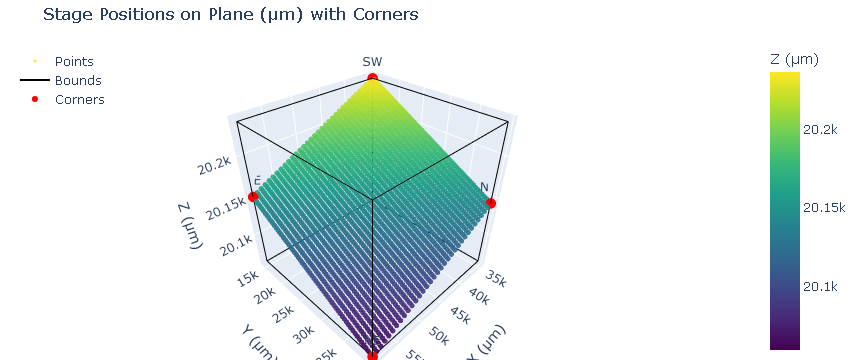

,corner,Index,Label,X_um,Y_um,Z_um
0,SW,0,Pos-2-000_000,34471.259064,14594.892382,20236.375247
1,NW,2107,Pos-2-000_061,34471.259064,39726.892382,20143.989268
2,SE,33,Pos-2-033_000,59155.259064,14594.892382,20152.271234
3,NE,2074,Pos-2-033_061,59155.259064,39726.892382,20059.885255


In [16]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display

# --- Use df2 (already on the plane) ---
cols = ["X_um", "Y_um", "Z_um"]
df_xyz = df2.dropna(subset=cols).copy()

# --- Ranges ---
x0, x1 = float(df_xyz["X_um"].min()), float(df_xyz["X_um"].max())
y0, y1 = float(df_xyz["Y_um"].min()), float(df_xyz["Y_um"].max())
z0, z1 = float(df_xyz["Z_um"].min()), float(df_xyz["Z_um"].max())

# --- Helper: nearest point to target XY ---
def nearest_row_to_xy(d, x0, y0):
    idx = ((d["X_um"] - x0)**2 + (d["Y_um"] - y0)**2).idxmin()
    row = d.loc[idx, ["Index","Label","X_um","Y_um","Z_um"]] \
            if "Index" in d.columns or "Label" in d.columns else \
           d.loc[idx, ["X_um","Y_um","Z_um"]]
    return row

# --- Find XY corners in df2 space ---
corner_names = ["SW","NW","SE","NE"]
corner_xy    = [(x0,y0), (x0,y1), (x1,y0), (x1,y1)]
corner_rows  = [nearest_row_to_xy(df_xyz, *xy) for xy in corner_xy]
corners_df   = pd.DataFrame(corner_rows).reset_index(drop=True)
corners_df.insert(0, "corner", corner_names)

# --- Scatter of points ---
pts = go.Scatter3d(
    x=df_xyz["X_um"], y=df_xyz["Y_um"], z=df_xyz["Z_um"],
    mode="markers",
    marker=dict(size=3, opacity=0.9, color=df_xyz["Z_um"],
                colorscale="Viridis", colorbar=dict(title="Z (µm)")),
    hovertemplate=("Index: %{customdata[0]}<br>"
                   "Label: %{customdata[1]}<br>"
                   "X: %{x:.2f} µm<br>"
                   "Y: %{y:.2f} µm<br>"
                   "Z: %{z:.2f} µm"),
    customdata=np.stack([
        df_xyz.get("Index", np.arange(len(df_xyz))),
        df_xyz.get("Label", [""]*len(df_xyz))
    ], axis=1),
    name="Points"
)

# --- Bounding box ---
def box_edges(x0,x1,y0,y1,z0,z1):
    V = [(x0,y0,z0),(x1,y0,z0),(x1,y1,z0),(x0,y1,z0),
         (x0,y0,z1),(x1,y0,z1),(x1,y1,z1),(x0,y1,z1)]
    E = [(0,1),(1,2),(2,3),(3,0),(4,5),(5,6),(6,7),(7,4),(0,4),(1,5),(2,6),(3,7)]
    xs, ys, zs = [], [], []
    for a,b in E:
        xs += [V[a][0], V[b][0], None]
        ys += [V[a][1], V[b][1], None]
        zs += [V[a][2], V[b][2], None]
    return go.Scatter3d(x=xs, y=ys, z=zs, mode="lines",
                        line=dict(color="black", width=2),
                        name="Bounds", hoverinfo="skip")

box = box_edges(x0,x1,y0,y1,z0,z1)

# --- Red corner markers + labels ---
corner_trace = go.Scatter3d(
    x=corners_df["X_um"], y=corners_df["Y_um"], z=corners_df["Z_um"],
    mode="markers+text",
    marker=dict(size=6, color="red"),
    text=corners_df["corner"],
    textposition="top center",
    name="Corners"
)

# --- Figure ---
fig = go.Figure(data=[pts, box, corner_trace])
fig.update_layout(
    title="Stage Positions on Plane (µm) with Corners",
    scene=dict(
        xaxis_title="X (µm)", yaxis_title="Y (µm)", zaxis_title="Z (µm)",
        aspectmode="cube", xaxis=dict(nticks=6), yaxis=dict(nticks=6), zaxis=dict(nticks=6),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.02)
)
fig.show()

# --- Corner coordinates table below the plot ---
cols_to_show = ["corner","Index","Label","X_um","Y_um","Z_um"] \
    if "Index" in corners_df.columns or "Label" in corners_df.columns \
    else ["corner","X_um","Y_um","Z_um"]
display(corners_df[cols_to_show])


In [17]:
# Final cell: write plane-linearized coordinates back to a Micro-Manager Property Map .pos
import json, numpy as np, pandas as pd
from pathlib import Path

# posfile must be defined in the first cell, df2 must exist, and A,B,C,n from the plane fit
# Example:
# posfile = "C:/Users/MITLENR/Desktop/tastrak92b-calib3.pos"

def prop_scalar(d, key, default=None):
    """Helper for MM Property Map leaves: returns d[key]['scalar'] if present."""
    v = d.get(key)
    if isinstance(v, dict) and "scalar" in v:
        return v["scalar"]
    return default

def update_mm_property_map_pos_with_new_z(data_obj: dict, df2: pd.DataFrame) -> dict:
    """
    Replace the Z (um) in each stage position with df2['Z_um'] mapped by df2['Index'].
    Prefers the default Z stage; otherwise updates the first 1-D Position_um entry.
    """
    new_obj = json.loads(json.dumps(data_obj))  # deep copy, keep structure

    entries = new_obj.get("map", {}) \
                     .get("StagePositions", {}) \
                     .get("array", [])
    if not isinstance(entries, list):
        raise ValueError("Unexpected .pos structure: StagePositions.array missing")

    # Map Index -> new Z (µm). Fall back to positional index if 'Index' is missing.
    if "Index" in df2.columns:
        idx_seq = df2["Index"].to_list()
    else:
        idx_seq = list(range(len(df2)))
    z_seq = df2["Z_um"].astype(float).to_list()
    z_map = dict(zip(idx_seq, z_seq))

    # Walk positions and update Z
    for i, e in enumerate(entries):
        if i not in z_map or pd.isna(z_map[i]):
            continue
        new_z = float(z_map[i])

        devpos = e.get("DevicePositions", {})
        dev_entries = devpos.get("array", []) if isinstance(devpos, dict) else []
        default_z = prop_scalar(e, "DefaultZStage", None)
        updated = False

        # Prefer default Z stage entry if available
        if isinstance(dev_entries, list):
            for dpe in dev_entries:
                dev_name = prop_scalar(dpe, "Device", None)
                pos = dpe.get("Position_um", {})
                arr = pos.get("array", []) if isinstance(pos, dict) else []
                # 1-D array is a Z-like device; pick default Z if declared
                if (default_z and dev_name == default_z and len(arr) >= 1) or (len(arr) == 1):
                    arr[0] = new_z
                    updated = True
                    break

        # Fallback: rare flat 'z' property
        if not updated and "z" in e and isinstance(e["z"], dict) and "scalar" in e["z"]:
            e["z"]["scalar"] = new_z

    return new_obj

# --- Load, update, write ---
p = Path(posfile)
with open(p, "r", encoding="utf-8", errors="ignore") as f:
    data = json.load(f)

updated = update_mm_property_map_pos_with_new_z(data, df2)

out_pos = p.with_name(f"{p.stem}_fitted{p.suffix}")  # same folder, add _fitted before .pos
out_pos.write_text(json.dumps(updated, indent=2), encoding="utf-8")

# --- Summary (ignores NaNs in deltaZ) ---
summary = pd.DataFrame([{
    "A": float(A), "B": float(B), "C": float(C),
    "normal_nx": float(n[0]), "normal_ny": float(n[1]), "normal_nz": float(n[2]),
    "RMS_deltaZ_um": float(np.sqrt(np.nanmean((df2["deltaZ_um"]**2).to_numpy()))),
    "Max_abs_deltaZ_um": float(np.nanmax(np.abs(df2["deltaZ_um"]).to_numpy())),
    "N_points": int(len(df2)),
    "Written_to": str(out_pos)
}])
summary


,A,B,C,normal_nx,normal_ny,normal_nz,RMS_deltaZ_um,Max_abs_deltaZ_um,N_points,Written_to
0,-0.003407,-0.003676,20407.47794,-0.003407,-0.003676,-0.999987,8.326596,23.020455,2108,C:\Users\MITLENR\Desktop\tastrak92b-calib3_fit...
